# Set up

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [4]:
def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [5]:
def show_training_history(history, last_epoch = None):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
    if 'val_loss' in history.history:
        ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss', axes = ax[0])
    if last_epoch is not None:
        ax[0].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[0].legend(loc = 'best', shadow = True)
    ax[1].plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
    if 'val_accuracy' in history.history:
        ax[1].plot(history.history['val_accuracy'], color = 'r',label = 'Validation accuracy')
    if last_epoch is not None:
        ax[1].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[1].legend(loc = 'best', shadow = True)
    plt.show()

# Dataset

In [6]:
from sklearn.datasets import make_classification

x, y = make_classification(n_samples = 1_000, n_classes = 4, n_features = 10, n_informative = 8)
ds = pd.DataFrame(x, columns = [f'x{i + 1}' for i in range(x.shape[1])])
ds['y'] = y
ds

x1        x2        x3        x4        x5  ...        x7  \
0   -4.078365 -0.365335 -3.919372 -0.951142  1.303022  ... -3.647173   
1    0.106117  1.500280 -0.068536  0.783502 -0.253842  ... -2.631136   
2   -0.693856 -0.155616  5.664426 -0.419915  3.365466  ... -2.257764   
3    0.445520  2.505495 -0.161959 -0.711955  1.301512  ...  2.536574   
4    4.507607  1.014782  5.657605  0.963729 -0.289909  ...  0.417008   
..        ...       ...       ...       ...       ...  ...       ...   
995 -0.439999  2.766100  1.068407  0.040798 -0.709289  ...  1.523186   
996  1.007814  0.783298 -2.288639  2.314821 -0.960589  ...  1.367956   
997  2.889092 -0.232701 -0.049998 -1.588416 -0.708690  ...  1.795430   
998  0.331308 -1.200399  0.684247  0.716491 -1.046580  ... -2.187550   
999  0.853003  1.689436  5.063312  1.542984 -0.618841  ...  0.266492   

           x8        x9       x10  y  
0   -0.104811 -1.720296 -2.361984  3  
1   -0.066100 -2.057390 -1.424741  3  
2   -0.110174  1.868149  6.376854  3  
3    1.569849 -0.321975 -0.290595  2  
4    1.071299  1.367607  3.464227  1  
..        ...       ...       ... ..  
995  1.247387 -1.100071  0.028769  2  
996  1.410251  1.336146 -2.599961  3  
997  1.085299 -0.263235 -0.446507  0  
998  1.661735  2.381833 -0.954852  0  
999  1.063788  2.550016  0.851044  2  

[1000 rows x 11 columns]

## Dataset lookup

In [7]:
def dataset_lookup(df):
    print('Dataset info:')
    print(df.info())
    print()
    print('Dataset description:')
    print(df.describe())
    print()
    print('Amount of duplicates:')
    duplicates_amount = df.duplicated().sum()
    print(duplicates_amount)
    if (duplicates_amount > 0):
        print('Duplicates:')
        print(df[df.duplicated()])
    print()
    print('Amount of missing values:')
    print(df.isna().sum(axis = 0))
    print()
    print('Unique values in each column:')
    object_types_count = 0
    for column in df:
        if df[column].dtypes == 'object':
            object_types_count += 1
            print('-' * len(column))
            print(f'{column}: {df[column].unique()}')
    if object_types_count == 0:
        print('-' * 10)
        print('No object columns in this dataset.')
            
dataset_lookup(ds)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
 3   x4      1000 non-null   float64
 4   x5      1000 non-null   float64
 5   x6      1000 non-null   float64
 6   x7      1000 non-null   float64
 7   x8      1000 non-null   float64
 8   x9      1000 non-null   float64
 9   x10     1000 non-null   float64
 10  y       1000 non-null   int32  
dtypes: float64(10), int32(1)
memory usage: 82.2 KB
None

Dataset description:
                x1           x2           x3           x4           x5  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     -0.294812    -0.095619    -0.264479    -0.406615     0.007163  ...   
std       1.998263     1.774988     2.499411     2.719640     1.816184  ...   
min 

## Dataset showcase

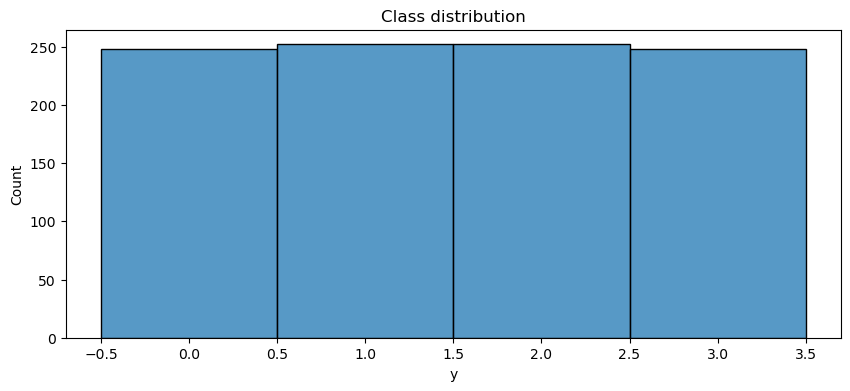

In [9]:
def show_class_distribution(y, encoder = None):
    plt.figure(figsize = (10, 4))
    plt.title('Class distribution')
    if encoder != None:
        sb.histplot(encoder.inverse_transform(y), discrete = True)
    else:
        sb.histplot(y, discrete = True)
    plt.show()
    
show_class_distribution(ds['y'])

In [10]:
def plot_dataset_histograms(df):
    df.hist()
    plt.show()

plot_dataset_histograms(ds)

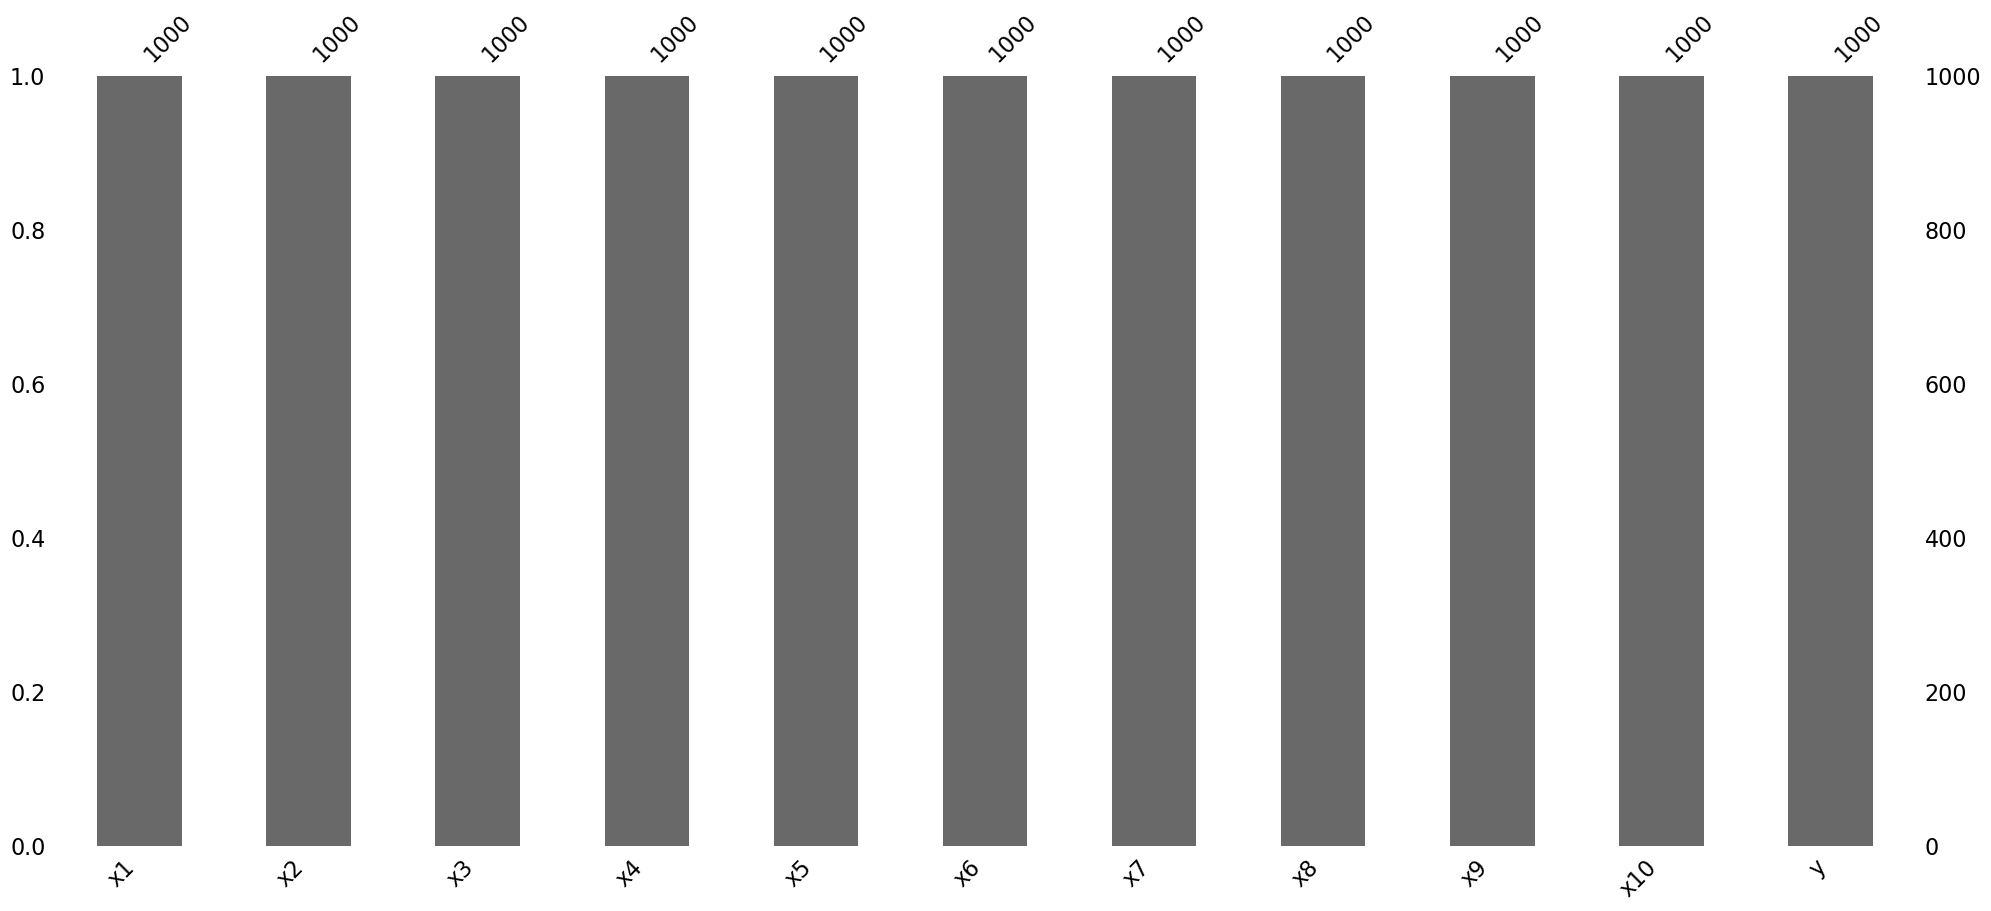

In [11]:
msno.bar(ds)
plt.show()

<Figure size 1500x1500 with 0 Axes>

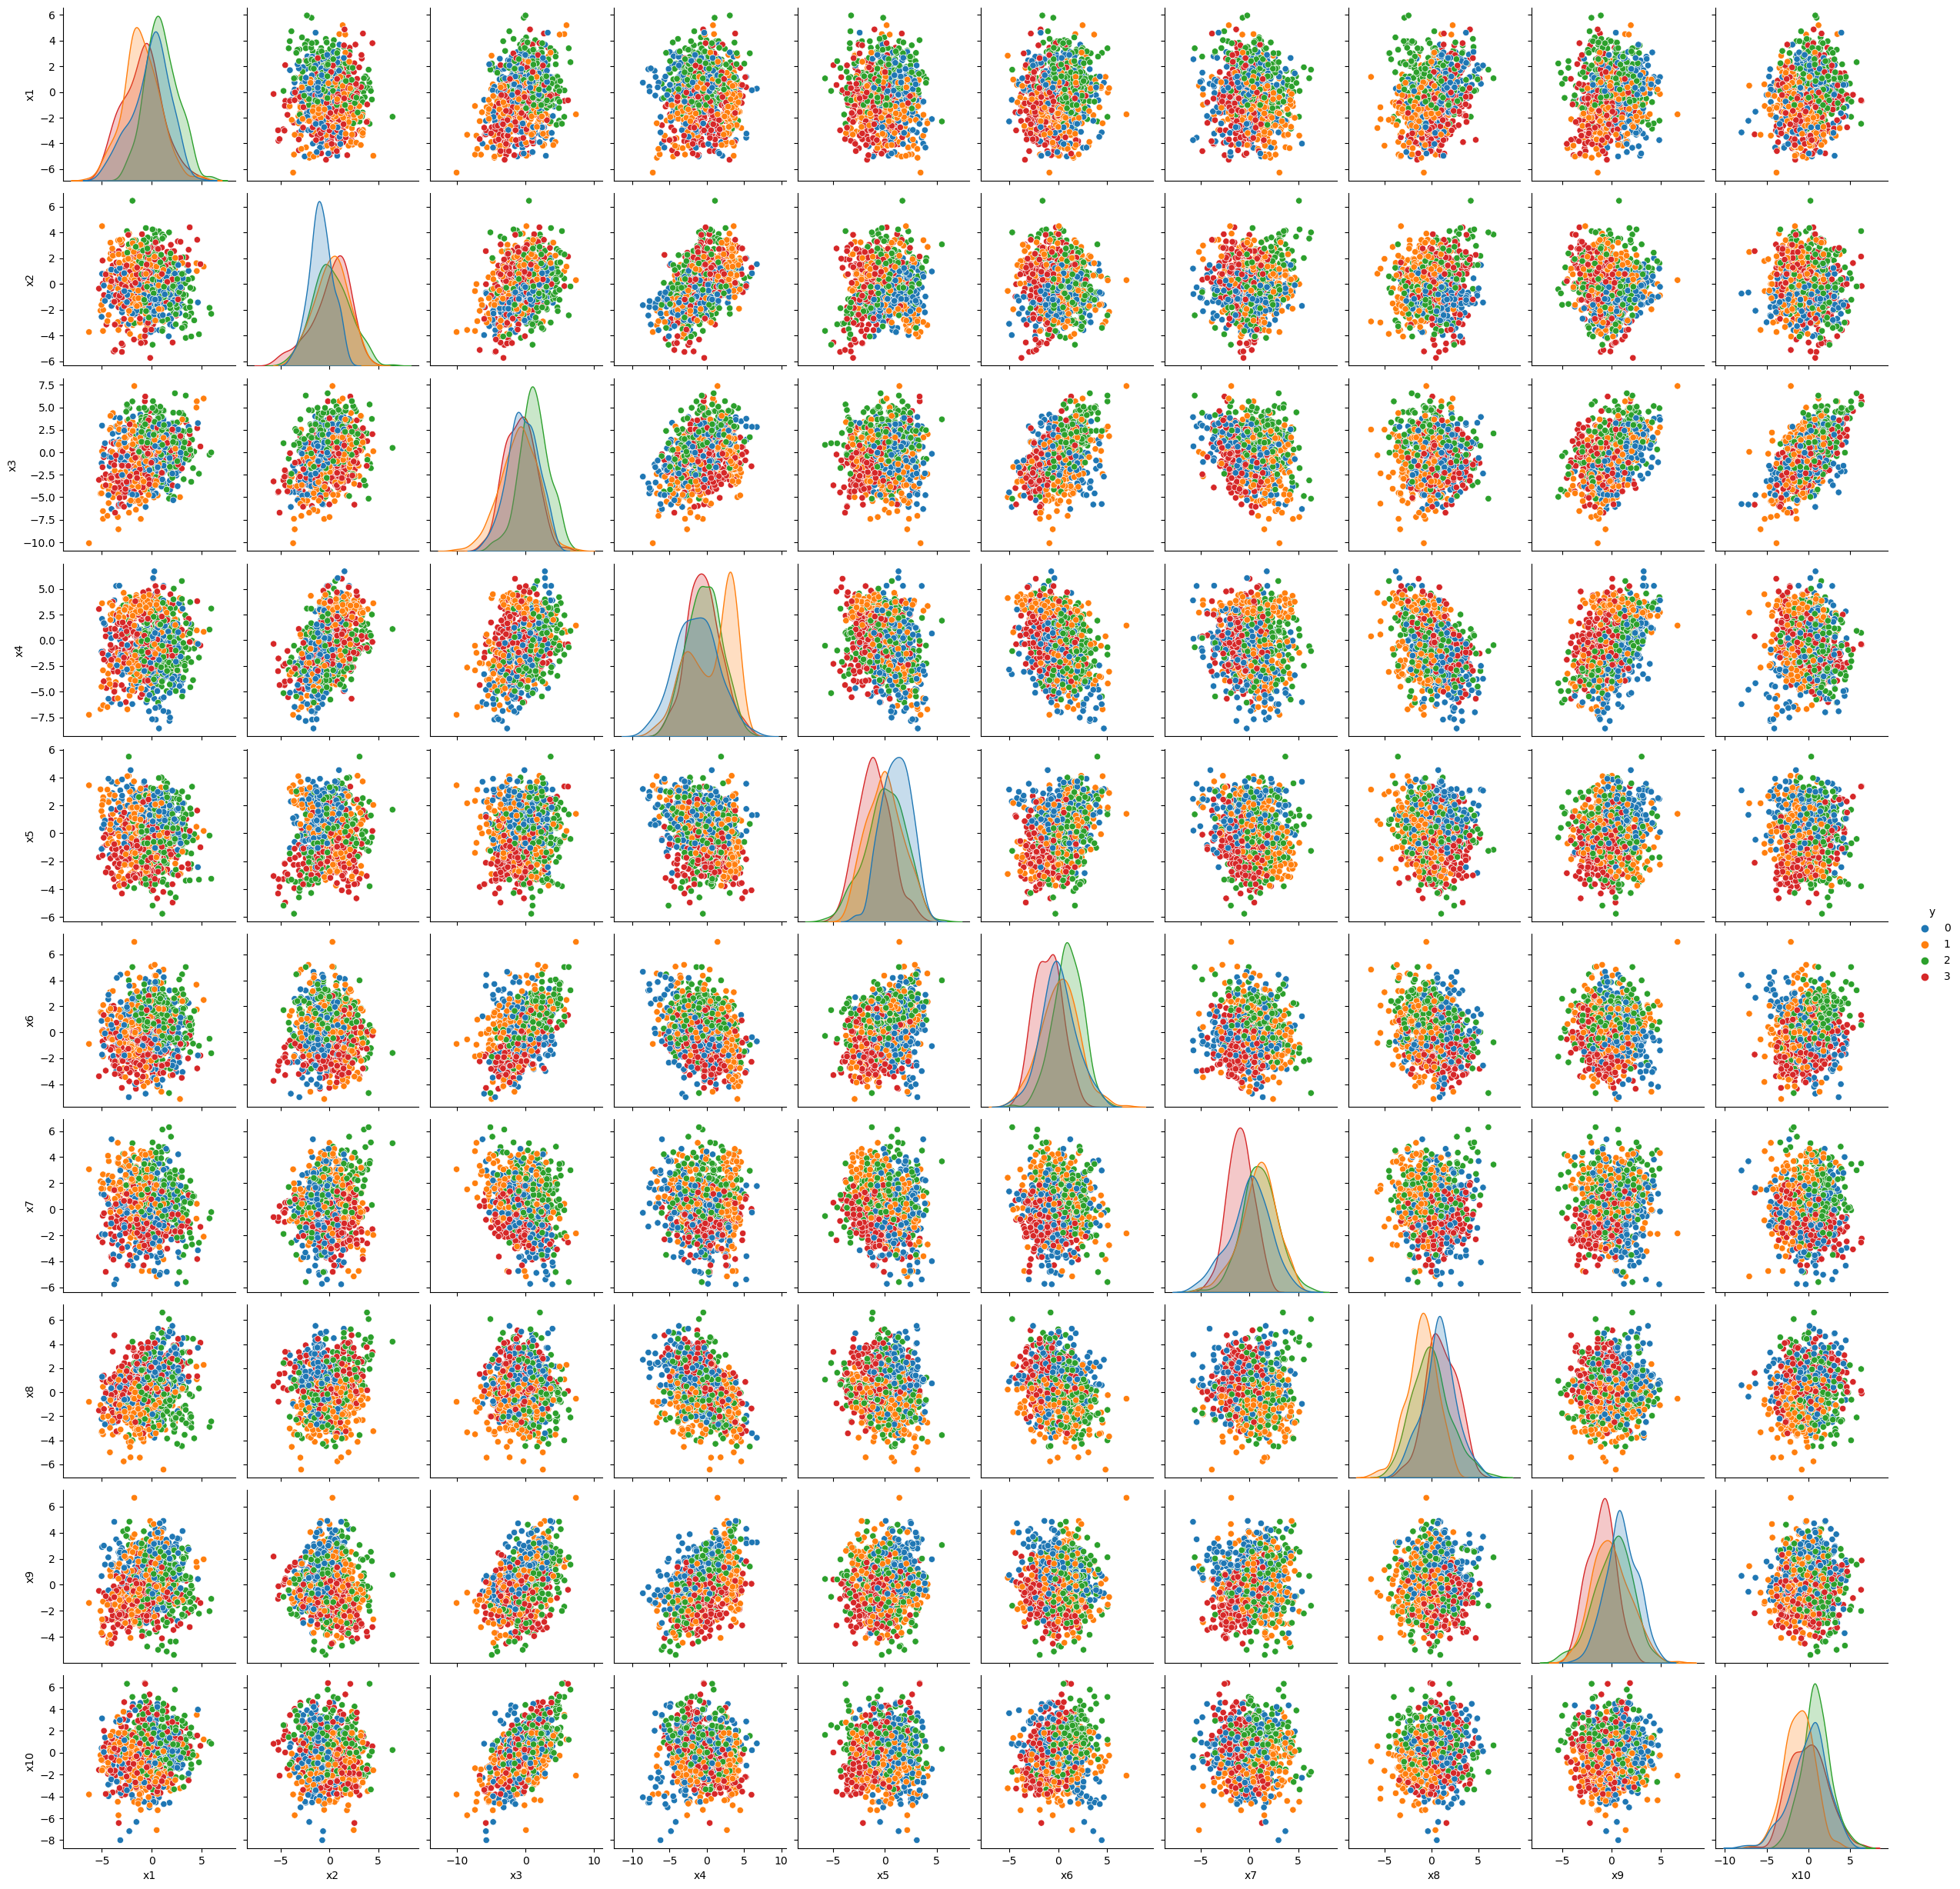

In [12]:
def show_pair_plot(df, figure_size = (15, 15), target_name = None):
    plt.figure(figsize = figure_size)
    sb.pairplot(df.select_dtypes(exclude = ['object']), palette = 'tab10', hue = target_name)
    plt.show()
    
show_pair_plot(ds, target_name = 'y')

In [13]:
def show_cat_plot(df):
    sb.catplot(df, kind = 'boxen', height = 8)
    plt.show()

show_cat_plot(ds)

In [14]:
def show_correlation_map(df, figure_size = (15, 15)):
    plt.figure(figsize = figure_size)
    sb.heatmap(
        df.select_dtypes(exclude = ['object']).corr(),
        annot = True,
        cmap = 'coolwarm',
        fmt = '.2f')
    plt.show()

show_correlation_map(ds)

# Preprocessing

In [15]:
y = ds['y']
scaler = StandardScaler()
ds_without_y = ds.drop(columns = ['y'])
x = pd.DataFrame(
    scaler.fit_transform(ds_without_y),
    columns = list(ds_without_y.columns))
x

x1        x2        x3        x4        x5        x6        x7  \
0   -1.894368 -0.152030 -1.463033 -0.200320  0.713864 -1.105435 -1.967628   
1    0.200739  0.899554  0.078435  0.437820 -0.143783 -0.018719 -1.454750   
2   -0.199796 -0.033818  2.373308 -0.004893  1.850024  0.435848 -1.266279   
3    0.370673  1.466160  0.041038 -0.112329  0.713032  0.098174  1.153818   
4    2.404499  0.625895  2.370577  0.504122 -0.163651  0.953702  0.083899   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.072693  1.613054  0.533547  0.164594 -0.394679  0.426544  0.642278   
996  0.652205  0.495416 -0.810260  1.001161 -0.533116 -1.439929  0.563921   
997  1.594133 -0.077268  0.085855 -0.434760 -0.394350  0.613923  0.779702   
998  0.313489 -0.622727  0.379769  0.413168 -0.580487 -0.312990 -1.230836   
999  0.574694  1.006175  2.132685  0.717218 -0.344853  1.418198  0.007921   

           x8        x9       x10  
0   -0.159510 -0.937849 -1.110181  
1   -0.139630 -1.119350 -0.661210  
2   -0.162265  0.994261  3.076008  
3    0.700510 -0.184957 -0.117918  
4    0.444480  0.724757  1.680765  
..        ...       ...       ...  
995  0.534910 -0.603904  0.035068  
996  0.618549  0.707817 -1.224179  
997  0.451670 -0.153330 -0.192604  
998  0.747698  1.270842 -0.436119  
999  0.440623  1.361396  0.428965  

[1000 rows x 10 columns]

# Dataset split

In [16]:
from sklearn.model_selection import train_test_split

x_train_, x_test, y_train_, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42, shuffle = True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.1, random_state = 42)

print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (675, 10)
y train: (675,)

x test: (250, 10)
y test: (250,)

x validation: (75, 10)
y validation: (75,)


# Cross-validation

## Non-ensemble methods

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = []
models.append(('LR', LogisticRegression(random_state = 42, n_jobs = -1)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 20, n_jobs = -1)))
models.append(('GNB', GaussianNB()))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, x, y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: mean - {cv_results.mean()}; std - {cv_results.std()}')
plt.boxplot(results, labels = names)
plt.title('Algorithms comparison')
plt.show()

LR: mean - 0.698; std - 0.017204650534085215
KNN: mean - 0.8640000000000001; std - 0.029393876913398165
GNB: mean - 0.693; std - 0.022045407685048576


## Ensemble methods

LR: mean - 0.698; std - 0.017204650534085215
KNN: mean - 0.8640000000000001; std - 0.029393876913398165
GNB: mean - 0.693; std - 0.022045407685048576
CART: mean - 0.681; std - 0.025961509971494313
RF: mean - 0.844; std - 0.022671568097509257
XT: mean - 0.8550000000000001; std - 0.021679483388678818
BG: mean - 0.7870000000000001; std - 0.022271057451320065
ADA: mean - 0.6609999999999999; std - 0.03826225293941797
HG: mean - 0.8450000000000001; std - 0.01140175425099139
XGB: mean - 0.834; std - 0.015937377450509202
CAT: mean - 0.866; std - 0.020346989949375824


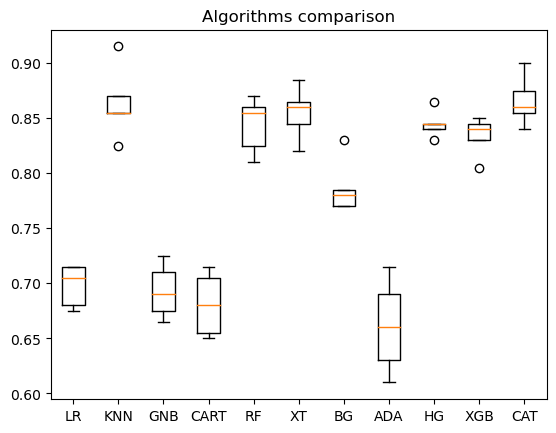

In [19]:
models.append(('CART', DecisionTreeClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(n_jobs = -1, random_state = 42)))
models.append(('XT', ExtraTreesClassifier(n_jobs = -1, random_state = 42)))
models.append(('BG', BaggingClassifier(n_jobs = -1, random_state = 42)))
models.append(('ADA', AdaBoostClassifier(random_state = 42)))
models.append(('HG', HistGradientBoostingClassifier(random_state = 42)))
models.append(('XGB', XGBClassifier(tree_method = 'gpu_hist', verbosity = 0, random_state = 42)))
models.append(('CAT', CatBoostClassifier(
    random_seed = 42,
    loss_function = 'MultiClass',
    eval_metric = 'Accuracy',
    od_type = 'Iter',
    od_wait = 20,
    task_type = 'GPU',
    logging_level = 'Silent')))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, x, y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: mean - {cv_results.mean()}; std - {cv_results.std()}')
plt.boxplot(results, labels = names)
plt.title('Algorithms comparison')
plt.show()

# Grid search for Random Forest classifier

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 16, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.82      0.81      0.82        69
           1       0.75      0.88      0.81        52
           2       0.92      0.82      0.87        73
           3       0.89      0.89      0.89        56

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250



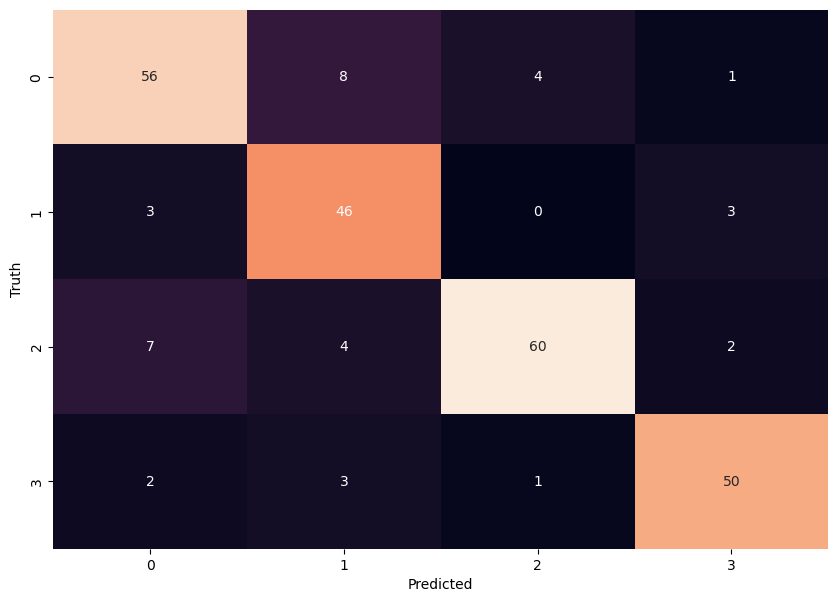

In [20]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [8, 16, 32]
}

clf = RandomForestClassifier(random_state = 42)
clf.fit(x_train, y_train)
gs = GridSearchCV(estimator = clf, cv = 5, param_grid = parameters, n_jobs = -1, verbose = 4)     
gs.fit(x_train, y_train)

print(f'Best parameters: {gs.best_params_}')
clf.set_params(**gs.best_params_)

y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
show_confusion_matrix(y_test, y_pred)

# Multilayer perceptron

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, ReLU
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
# Image preprocessing
from keras.layers import Rescaling, Resizing, CenterCrop
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast

# List of devices
tf.config.list_physical_devices()

# Plot model function
# keras.utils.plot_model(model, show_shapes = True)

# Model loading function
# model = keras.models.load_model('model.keras', compile = False)
# model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.summary()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
print(encoder.inverse_transform([0]))
labels = list(encoder.classes_)
print(labels)

[0]
[0, 1, 2, 3]


---
Training for fold 1...
Epoch 1/10
25/25 [==============================] - 1s 6ms/step - loss: 1.3463 - accuracy: 0.3462
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 1.2524 - accuracy: 0.4575
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.1441 - accuracy: 0.5650
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 1.0398 - accuracy: 0.6037
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9421 - accuracy: 0.6500
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8773 - accuracy: 0.6888
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8370 - accuracy: 0.6750
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7850 - accuracy: 0.7075
Epoch 9/10
25/25 [==============================] - 0s 5ms/step - loss: 0.7413 - accuracy: 0.7237
Epoch 10/10
25/25 [==============================] - 0s 5ms/step - loss: 0.7377 - accuracy:

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        49
           1       0.79      0.73      0.76        51
           2       0.80      0.80      0.80        50
           3       0.81      0.88      0.85        50

    accuracy                           0.80       200
   macro avg       0.79      0.80      0.79       200
weighted avg       0.79      0.80      0.79       200



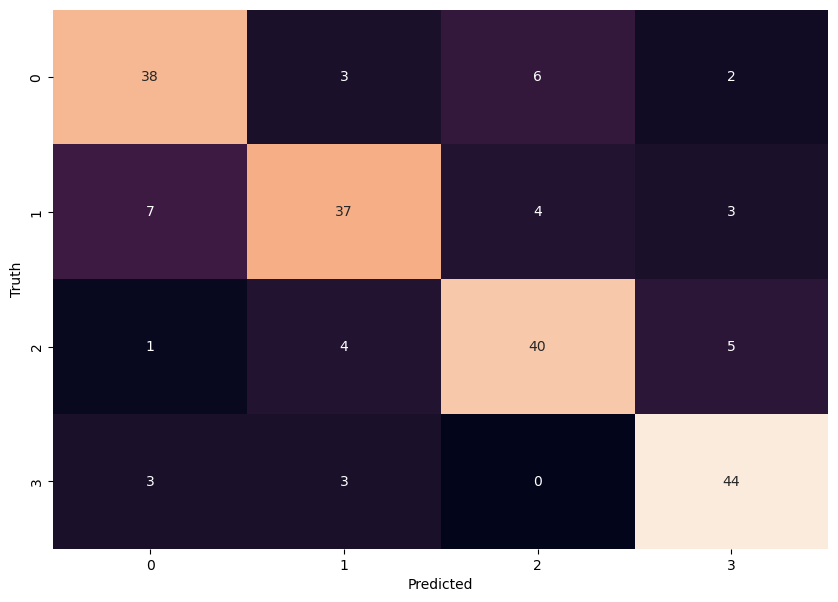

---
Training for fold 2...
Epoch 1/10
25/25 [==============================] - 1s 6ms/step - loss: 1.3549 - accuracy: 0.3600
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.2217 - accuracy: 0.5213
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.0984 - accuracy: 0.5962
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9435 - accuracy: 0.6525
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8654 - accuracy: 0.6737
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.8346 - accuracy: 0.6550
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7635 - accuracy: 0.7088
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7840 - accuracy: 0.7163
Epoch 9/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7241 - accuracy: 0.7113
Epoch 10/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy:

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        49
           1       0.85      0.92      0.89        51
           2       0.79      0.90      0.84        50
           3       0.91      0.82      0.86        50

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



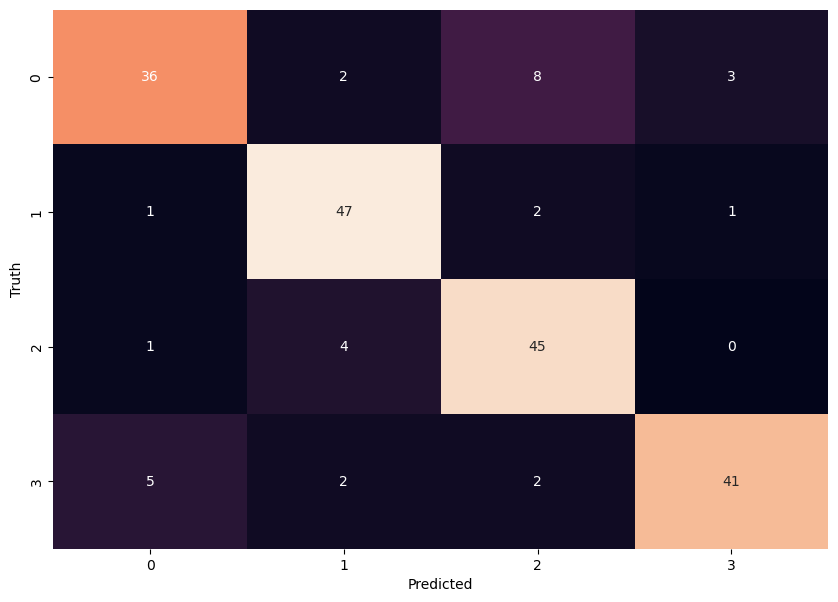

---
Training for fold 3...
Epoch 1/10
25/25 [==============================] - 1s 6ms/step - loss: 1.3363 - accuracy: 0.3775
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 1.1470 - accuracy: 0.5562
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.0540 - accuracy: 0.5800
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9164 - accuracy: 0.6325
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8749 - accuracy: 0.6662
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7903 - accuracy: 0.6900
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7776 - accuracy: 0.6837
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7254 - accuracy: 0.7063
Epoch 9/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7143 - accuracy: 0.7225
Epoch 10/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6765 - accuracy:

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        50
           1       0.76      0.74      0.75        50
           2       0.72      0.82      0.77        50
           3       0.86      0.84      0.85        50

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200



---
Training for fold 4...
Epoch 1/10
25/25 [==============================] - 1s 6ms/step - loss: 1.3642 - accuracy: 0.3262
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 1.2289 - accuracy: 0.4800
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.0874 - accuracy: 0.5838
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.9686 - accuracy: 0.6400
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8926 - accuracy: 0.6662
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8182 - accuracy: 0.6888
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7893 - accuracy: 0.6938
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7282 - accuracy: 0.7200
Epoch 9/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7202 - accuracy: 0.7212
Epoch 10/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6869 - accuracy:

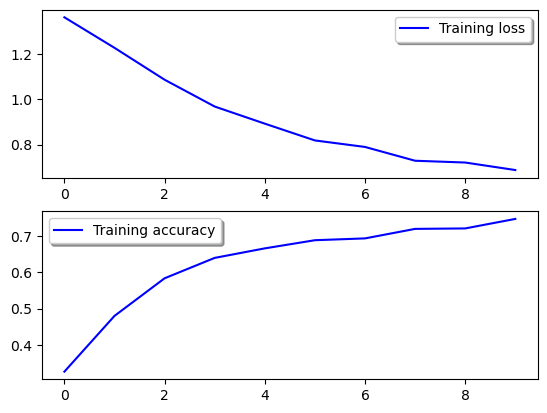

              precision    recall  f1-score   support

           0       0.67      0.74      0.70        50
           1       0.71      0.68      0.69        50
           2       0.78      0.82      0.80        51
           3       0.95      0.84      0.89        49

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200



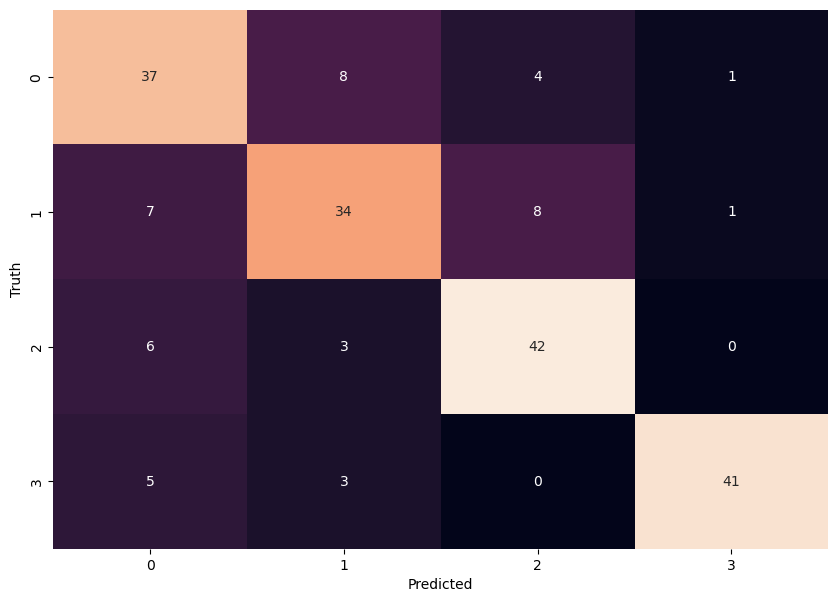

---
Training for fold 5...
Epoch 1/10
25/25 [==============================] - 1s 6ms/step - loss: 1.3948 - accuracy: 0.3025
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 1.2708 - accuracy: 0.4375
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 1.1292 - accuracy: 0.5425
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 1.0524 - accuracy: 0.5688
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9406 - accuracy: 0.6075
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8429 - accuracy: 0.6538
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.7759 - accuracy: 0.6950
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7903 - accuracy: 0.6913
Epoch 9/10
25/25 [==============================] - 0s 7ms/step - loss: 0.7002 - accuracy: 0.7325
Epoch 10/10
25/25 [==============================] - 0s 8ms/step - loss: 0.6873 - accuracy:

              precision    recall  f1-score   support

           0       0.73      0.72      0.73        50
           1       0.69      0.68      0.69        50
           2       0.71      0.88      0.79        51
           3       0.85      0.67      0.75        49

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



---
Score per fold
---
> Fold 1 - Loss: 0.5912736654281616 - Accuracy: 79.50000166893005%
---
> Fold 2 - Loss: 0.48833778500556946 - Accuracy: 84.50000286102295%
---
> Fold 3 - Loss: 0.6284213662147522 - Accuracy: 77.49999761581421%
---
> Fold 4 - Loss: 0.5626487135887146 - Accuracy: 76.99999809265137%
---
> Fold 5 - Loss: 0.6735166311264038 - Accuracy: 74.00000095367432%
---
Average scores for all folds:
> Accuracy: 0.7850000023841858 (+- 0.03478506563958304)
> Loss: 0.5888396322727203
---


In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

batch_size = 32
epochs = 10
num_folds = 5
acc_per_fold = []
loss_per_fold = []
histories = []
kfold = StratifiedKFold(n_splits = num_folds, random_state = 42, shuffle = True)
fold_no = 1
for train, test in kfold.split(x, y):
    model = Sequential(
    [
        Input(shape = x_train.shape[1]),
        Dense(50, activation = 'relu'),
        Dropout(0.20),
        Dense(50, activation = 'relu'),
        Dropout(0.25),
        Dense(50, activation = 'relu'),
        Dropout(0.3),
        Dense(len(labels), activation = 'softmax')
    ])
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    print('---')
    print(f'Training for fold {fold_no}...')
    history = model.fit(
        x = x.iloc[train],
        y = y[train],
        batch_size = batch_size,
        epochs = epochs)
    histories.append(history)
    scores = model.evaluate(x.iloc[test], y[test], verbose = 0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    show_training_history(history)
    y_pred = np.argmax(model.predict(x.iloc[test], verbose = 0), axis = 1)
    print(classification_report(
        encoder.inverse_transform(y[test]),
        encoder.inverse_transform(y_pred)))
    show_confusion_matrix(y[test], y_pred, labels)
    fold_no = fold_no + 1
print('---')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('---')
    print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i] * 100}%')
print('---')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('---')
metrics = [loss_per_fold, acc_per_fold]
plt.boxplot(metrics, labels = ['Loss', 'Accuracy'])
plt.title('Metrics')
plt.show()